## North and South Perth Housing Analysis 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Analysing Price Trends between South and North of Perth 

In [3]:
# Read clean perth data
perth_housing_data = pd.read_csv('clean_perth_data.csv')
perth_housing_data.head()

,SUBURB,PRICE,BEDROOMS,BATHROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,MONTH_SOLD,YEAR_SOLD
0,South Lake,565000,4,2,600,2003,18300,Cockburn Central Station,1800,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,828,9,2018
1,Wandi,365000,3,2,351,2013,26900,Kwinana Station,4900,6167,-32.193470,115.859554,ATWELL COLLEGE,5524,2,2019
2,Camillo,287000,3,1,719,1979,22600,Challis Station,1900,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1649,6,2015
3,Bellevue,255000,2,1,651,1953,17900,Midland Station,3600,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1571,7,2018
4,Lockridge,325000,4,1,466,1998,11200,Bassendean Station,2000,6054,-31.885790,115.947780,KIARA COLLEGE,1514,1,2016


In [5]:
# Find the highest prices by postcode. 
max_price_postcode = pd.DataFrame(perth_housing_data.groupby(['POSTCODE'])['PRICE'].max())
sorted_prices = pd.DataFrame(max_price_postcode['PRICE'].sort_values(ascending=False))

In [7]:
# Top 10 Postcodes by Highest Prices
sorted_prices.head() 
#Format with commas. 

,PRICE
POSTCODE,
6014,2440000
6015,2437000
6009,2430000
6012,2425000
6020,2425000


In [5]:
#Bottom 10 Postcodes by Maximum Price
sorted_prices.tail()

,PRICE
POSTCODE,
6038,725000
6064,720000
6172,650000
6108,645000
6106,465000


In [6]:
# Find the top 5 and bottom 5 postcodes by avergae prices. 
average_prices= round(pd.DataFrame(perth_housing_data.groupby(['POSTCODE'])['PRICE'].mean()),2)
average_prices = pd.DataFrame(average_prices['PRICE'].sort_values(ascending=False))

In [7]:
average_prices.head()

,PRICE
POSTCODE,
6009,1691850.21
6011,1682567.53
6015,1644756.30
6010,1396749.36
6012,1383912.37


In [8]:
average_prices.tail()

,PRICE
POSTCODE,
6035,390656.25
6061,369746.55
6167,365194.96
6172,364402.60
6168,324897.52


In [9]:
# Divide the data into North and South of Perth. North postcode <=6000 and South postocdes >=6100
south_data = perth_housing_data.loc[(perth_housing_data['POSTCODE'] >= 6100) & (perth_housing_data['POSTCODE'] <=6200)]
north_data = perth_housing_data.loc[(perth_housing_data['POSTCODE'] <6100) & (perth_housing_data['POSTCODE'] >=6000)]

In [10]:
south_data.head()

,SUBURB,PRICE,BEDROOMS,BATHROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,MONTH_SOLD,YEAR_SOLD
0,South Lake,565000,4,2,600,2003,18300,Cockburn Central Station,1800,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,828,9,2018
1,Wandi,365000,3,2,351,2013,26900,Kwinana Station,4900,6167,-32.193470,115.859554,ATWELL COLLEGE,5524,2,2019
2,Camillo,287000,3,1,719,1979,22600,Challis Station,1900,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1649,6,2015
5,Mount Richon,409000,4,2,759,1991,27300,Armadale Station,1000,6112,-32.153801,116.023658,ARMADALE SENIOR HIGH SCHOOL,1227,3,2013
6,Hilbert,400000,3,2,386,2014,28200,Armadale Station,3700,6112,-32.179978,115.988647,DALE CHRISTIAN SCHOOL,2485,5,2016


In [11]:
# Analyse data from SOR. Average house prices SOR and sort into highest to lowest. 
average_south_prices= round(pd.DataFrame(south_data.groupby(['SUBURB'])['PRICE'].mean()),2)
average_south_prices = pd.DataFrame(average_south_prices['PRICE'].sort_values(ascending=False))

In [12]:
average_south_prices.head(10)

,PRICE
SUBURB,
Naval Base,1408000.00
Applecross,1396130.14
South Perth,1215011.11
North Fremantle,1213309.52
Mount Pleasant,1211815.64
Attadale,1208154.83
Salter Point,1185205.86
Rossmoyne,1165272.85
North Coogee,1136482.05


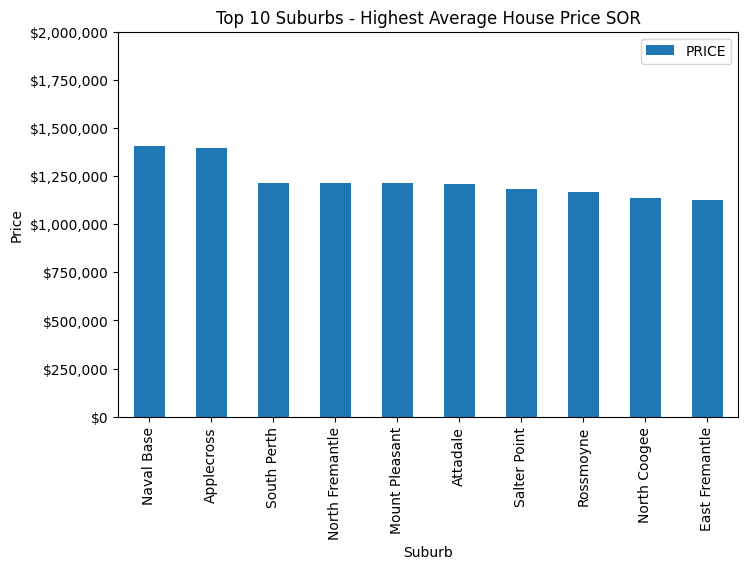

In [25]:
# Plot the top 10 suburbs average house SOR 
top_sor_plot = average_south_prices.head(10).plot(kind='bar', ylabel= "Price", ylim=(0,2000000), xlabel = "Suburb", figsize=(8,5), title= "Top 10 Suburbs - Highest Average House Price SOR")
top_sor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

In [15]:
# Analyse data from NOR. Average house prices NOR and sort into highest to lowest. 
average_north_prices= round(pd.DataFrame(north_data.groupby(['SUBURB'])['PRICE'].mean()),2)
average_north_prices = pd.DataFrame(average_north_prices['PRICE'].sort_values(ascending=False))

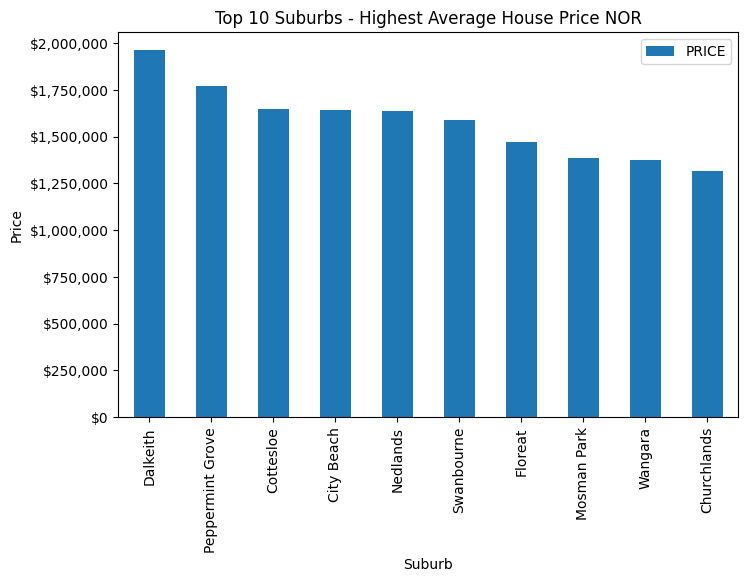

In [16]:
# Plot the Top 10 Suburbs house NOR
top_nor_plot = average_north_prices.head(10).plot(kind='bar', ylabel= "Price", xlabel = "Suburb", figsize=(8,5), title= "Top 10 Suburbs - Highest Average House Price NOR")
top_nor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

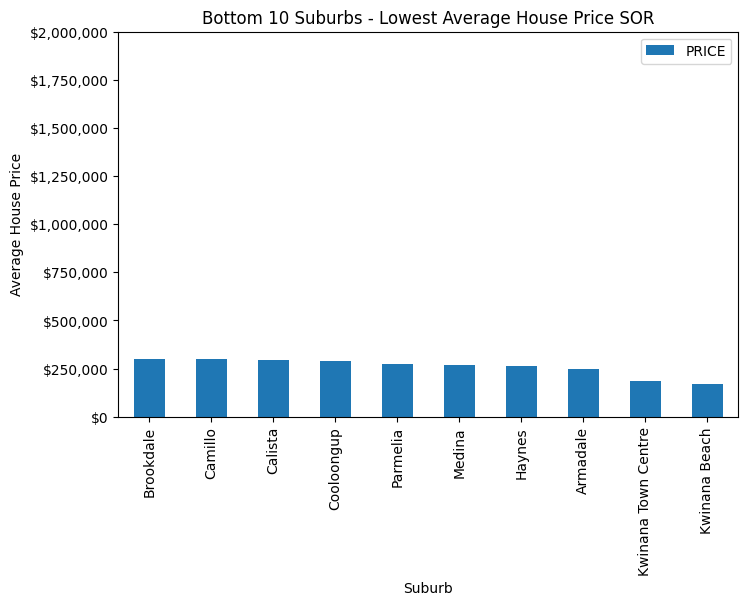

In [29]:
# Plot the Bottom 10 Suburbs house SOR 
bottom_sor_plot = average_south_prices.tail(10).plot(kind='bar', ylabel= "Average House Price", xlabel = "Suburb", ylim= (0,2000000), figsize=(8,5), title= "Bottom 10 Suburbs - Lowest Average House Price SOR")
bottom_sor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

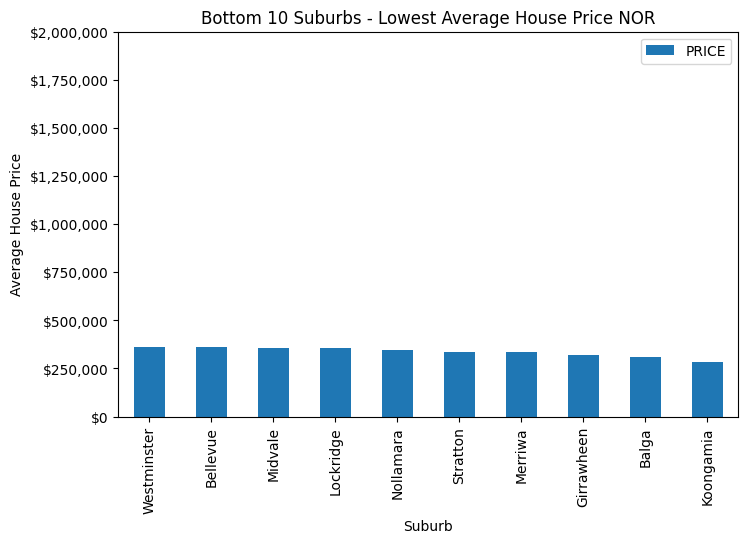

In [28]:
# Plot the Bottom 10 Suburbs house NOR 
bottom_nor_plot = average_north_prices.tail(10).plot(kind='bar', ylabel= "Average House Price", xlabel = "Suburb", ylim= (0,2000000), figsize=(8,5), title= "Bottom 10 Suburbs - Lowest Average House Price NOR")
bottom_nor_plot.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.show()

In [20]:
# Compare average house prices between NOR and SOR average over the years 
sor_average_price_by_year = south_data.groupby(['YEAR_SOLD'])['PRICE'].mean()
nor_average_price_by_year = north_data.groupby(['YEAR_SOLD'])['PRICE'].mean()

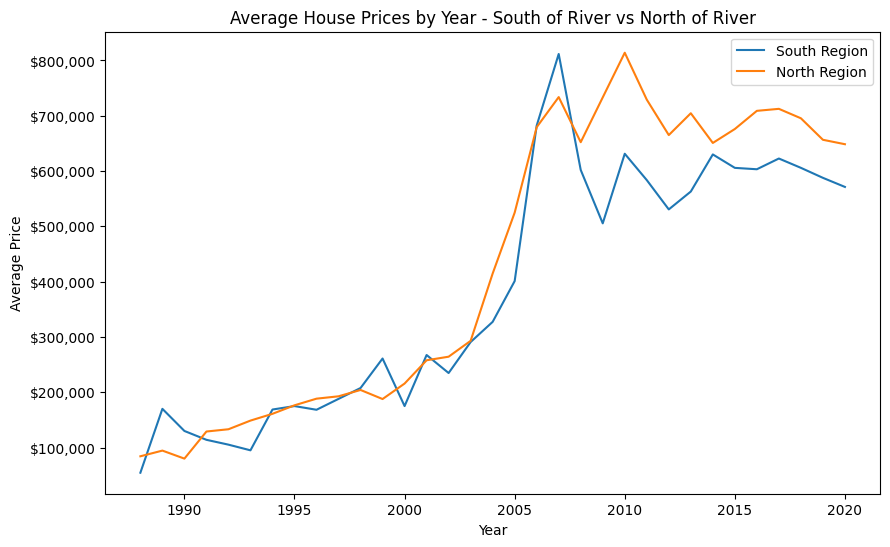

In [31]:
# Plotting the South region data as a line
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(sor_average_price_by_year.index, sor_average_price_by_year, label='South Region')

# Plotting the North region data as a line
ax1.plot(nor_average_price_by_year.index, nor_average_price_by_year, label='North Region')

# Adding labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Price')
ax1.set_title('Average House Prices by Year - South of River vs North of River')
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

# Adding a legend
ax1.legend()

# Display the plot
plt.show()

## Write analysis here: Generally house prices in North and South of River had no difference between the years. 

In [ ]:
# USE API to determine school type and whether PVT and GVT type determines house prices. 